In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Dropout, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential

In [52]:
path_to_dataset = "final_dataset.csv"
df = pd.read_csv(path_to_dataset)

df['time'] = pd.to_datetime(df['time'], utc = True)
df = df.set_index('time')

## 1. Feature Engineering

### 1.1. Feature Generation

We decompose time attribute into multiple attributes: hour, weekday, month.

In [53]:
# Generate 'hour', 'weekday' and 'month' features

for row_idx in range(df.shape[0]):
    row = df.index[row_idx]

    hour = row.hour
    weekday = row.weekday()
    month = row.month

    df.loc[row, 'hour'] = hour
    df.loc[row, 'weekday'] = weekday
    df.loc[row, 'month'] = month

We generate business_hour attribute from hour attribute should be split into business hour (equal to 1) and other hours (equal to 0).\
We assume work hours are from 8 am to 6 pm. Also, during the weekend, none of the hours is a work hour.

In [54]:
# Generate 'weekend' feature

for row_idx in range(df.shape[0]):
    row = df.index[row_idx]

    weekday = row.weekday()

    if (weekday == 6):
        df.loc[row, 'weekday'] = 2
    elif (weekday == 5):
        df.loc[row, 'weekday'] = 1
    else:
        df.loc[row, 'weekday'] = 0

In [55]:
# Generate 'business hour' feature

for row_idx in range(df.shape[0]):
    row = df.index[row_idx]

    weekday = row.weekday()
    hour = row.hour

    if (0 <= weekday <= 4 and 8 < hour < 18):
        df.loc[row, 'business hour'] = 1
    else:
        df.loc[row, 'business hour'] = 0

### 1.2. Feature Selection

In [56]:
X = df[df.columns.drop('price actual')].values
y = df['price actual'].values

y = y.reshape(-1, 1)

In [57]:
# Determine the train, validation, and test indices
n = df.shape[0]

train_end_idx = int(n * 0.7)        # 70% training
val_end_idx = int(n * 0.85)         # 15% validation, and the reamining 15% is for testing

The attributes have different units. We will use MinMax scaling to bring them to the same scale.\
The MinMaxScaler should be fit on the training data and the whole dataset should be transformed

In [58]:
scaler_X = MinMaxScaler(feature_range = (0, 1)) # the attributes will have valuies between 0 and 1
scaler_y = MinMaxScaler(feature_range = (0, 1))

# Fit MinMaxScaler on the training data
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [59]:
# Transform the dataset using MinMaxScaler after it was fit on the training data
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

Next, we use PCA to reduce the dimension of the dataset

In [60]:
# Apply PCA
pca = PCA(n_components = 0.95)  # keep enough components to explain 95% of variance
X_pca = pca.fit_transform(X_norm)

In [61]:
df = np.concatenate((X_pca, y_norm), axis = 1) # This is the updated df, post-Scaling and post-Scaling

In [62]:
history_size = 24 # This parameter will be used later in the forecasting models

def X_y_split(df: np.ndarray, target: np.ndarray, start_idx: int, end_idx: int, history_size: int = history_size):
    """
    Creates time series data samples (X) and labels (y) for supervised learning.

    Parameters:
        df (pd.DataFrame): Feature data (all variables).
        target (pd.DataFrame): Target variable to predict.
        start_idx (int): Starting index for data extraction.
        end_idx (int): Ending index (exclusive) for data extraction.
        history_size (int): Number of past time steps to use as input.

    Returns:
        X (np.ndarray): Array of shape (num_samples, history_size, num_features).
        y (np.ndarray): Array of shape (num_samples,), target values aligned with X.
    """
    X, y = [], []

    # Shift start index to ensure enough history exists for the first sample
    start_idx = start_idx + history_size

    for i in range(start_idx, end_idx):
        # Indices for the history window (from i-history_size to i-1)
        indices = range(i - history_size, i)

        # Extract feature data for these indices
        X.append(df[indices])   # Note: X contains values of y[i - history_size: i], the i-th is not included

        # Target value is at current time step i
        y.append(target[i])

    return np.array(X), np.array(y)

In [63]:
# Split the data into train, validate and test
X_train, y_train = X_y_split(df = df, target = df[:, -1], start_idx = 0, end_idx = train_end_idx)

X_val, y_val = X_y_split(df = df, target = df[:, -1], start_idx = train_end_idx, end_idx = val_end_idx)

X_test, y_test = X_y_split(df = df, target = df[:, -1], start_idx = val_end_idx, end_idx = df.shape[0])

Now we set some parameters that will be needed when training ML models using Tensorflow

In [6]:
models_path = "./models"

batch_size = 32
buffer_size = 1000

n_epochs = 100

In [65]:
tf_training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_training_data = tf_training_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

tf_validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
tf_validation_data = tf_validation_data.batch(batch_size).prefetch(1)

In [66]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test) # this is the inverse tranform not the inverse of vector y

In [67]:
# Define some common parameters
input_shape = X_train.shape[-2:]

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)

## 2. Electricity Price Forecasting

### 2.1 ARIMA (AutoRegressive Integrated Moving Average)

In [ ]:
# Combine train+val for model selection
y_train_val = np.concatenate([y_train, y_val])

# Define parameter ranges
p = d = q = range(0, 3)   # adjust if needed
P = D = Q = range(0, 2)   # seasonal params
m = 24                   # seasonal period length; 24 for hourly patterns - 365 for yearly patterns (require more compute resources)

# Generate all combinations of p,d,q and seasonal P,D,Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_score, best_cfg = float("inf"), None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(y_train_val, order = order, seasonal_order = seasonal_order, enforce_stationarity = False, enforce_invertibility = False)

            model_fit = model.fit(disp = False)

            # Forecast the next len(y_test) steps
            forecast = model_fit.forecast(steps = len(y_test))
            sarimax_forecast = forecast.reshape(-1, 1)

            # Inverse transform predictions back to original scale
            sarimax_forecast_inv = scaler_y.inverse_transform(sarimax_forecast)

            # Compute RMSE
            rmse_sarimax = np.sqrt(mean_squared_error(y_test_inv, sarimax_forecast_inv))

            if rmse_sarimax < best_score:
                best_score, best_cfg = rmse_sarimax, (order, seasonal_order)

            print(f"SARIMA{order}x{seasonal_order} - RMSE of hour-ahead electricity price ARIMA forecast: {rmse_sarimax:.3f}")

        except:
            continue

print(f"Best SARIMA{best_cfg[0]}x{best_cfg[1]} - RMSE: {best_score:.3f}")

SARIMA(0, 0, 0)x(0, 0, 0, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 60.259
SARIMA(0, 0, 0)x(0, 0, 1, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 60.164
SARIMA(0, 0, 0)x(0, 1, 0, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 8.802
SARIMA(0, 0, 0)x(0, 1, 1, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 8.383
SARIMA(0, 0, 0)x(1, 0, 0, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 43.703
SARIMA(0, 0, 0)x(1, 0, 1, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 11.401
SARIMA(0, 0, 0)x(1, 1, 0, 24) - RMSE of hour-ahead electricity price ARIMA forecast: 8.682


### 2.2 XGBoost

In [68]:
import xgboost as xgb

In [69]:
X_train_xgb = X_train.reshape(X_train.shape[0], -1)  # (num_samples, history_size * num_features)
X_val_xgb = X_val.reshape(X_val.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

In [70]:
# Parameters for XGBoost
param = {
    'eta': 0.03,                  # learning rate
    'max_depth': 6,               # max tree depth
    'subsample': 1.0,             # subsample ratio of training instances
    'colsample_bytree': 0.95,    # subsample ratio of columns per tree
    'alpha': 0.1,                 # L1 regularization term on weights
    'lambda': 0.15,               # L2 regularization term on weights
    'gamma': 0.1,                 # minimum loss reduction to make a split
    'objective': 'reg:squarederror',  # regression with squared error (use this instead of deprecated 'reg:linear')
    'eval_metric': 'rmse',
    'n_jobs': -1                  # use all cores
}

In [71]:
# Create DMatrix objects
dtrain = xgb.DMatrix(X_train_xgb, label = y_train)
dval = xgb.DMatrix(X_val_xgb, label = y_val)
dtest = xgb.DMatrix(X_test_xgb, label = y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params = param,
    dtrain = dtrain,
    num_boost_round = 180,
    evals = eval_list,
    early_stopping_rounds = 10,  # increased for more robustness
    verbose_eval = True  # Show training logs
)

[0]	train-rmse:0.13351	eval-rmse:0.13117
[1]	train-rmse:0.12976	eval-rmse:0.12754
[2]	train-rmse:0.12613	eval-rmse:0.12405
[3]	train-rmse:0.12308	eval-rmse:0.12135
[4]	train-rmse:0.11992	eval-rmse:0.11844
[5]	train-rmse:0.11659	eval-rmse:0.11525
[6]	train-rmse:0.11337	eval-rmse:0.11214
[7]	train-rmse:0.11025	eval-rmse:0.10914
[8]	train-rmse:0.10723	eval-rmse:0.10624
[9]	train-rmse:0.10431	eval-rmse:0.10343
[10]	train-rmse:0.10148	eval-rmse:0.10070
[11]	train-rmse:0.09897	eval-rmse:0.09843
[12]	train-rmse:0.09631	eval-rmse:0.09588
[13]	train-rmse:0.09374	eval-rmse:0.09342
[14]	train-rmse:0.09125	eval-rmse:0.09103
[15]	train-rmse:0.08884	eval-rmse:0.08871
[16]	train-rmse:0.08651	eval-rmse:0.08647
[17]	train-rmse:0.08426	eval-rmse:0.08431
[18]	train-rmse:0.08208	eval-rmse:0.08222
[19]	train-rmse:0.07997	eval-rmse:0.08021
[20]	train-rmse:0.07794	eval-rmse:0.07827
[21]	train-rmse:0.07597	eval-rmse:0.07640
[22]	train-rmse:0.07407	eval-rmse:0.07460
[23]	train-rmse:0.07224	eval-rmse:0.07288
[2

In [72]:
# Predict on test set and reshape
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

# Inverse transform predictions back to original scale
xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

# Compute RMSE between true and predicted (both in original scale)
rmse_xgb = np.sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))

print(f"RMSE of hour-ahead electricity price XGBoost forecast: {rmse_xgb:.3f}")

RMSE of hour-ahead electricity price XGBoost forecast: 2.206


### 2.3 LSTM (Long Short-Term Memory networks)

In [31]:
model_file = "multivariate_lstm.keras"

# Check if the directory and file exist
load_lstm_model = (
    os.path.isdir(models_path) and
    os.path.isfile(os.path.join(models_path, model_file))
)

tf.keras.backend.clear_session()

if load_lstm_model:
  multivariate_lstm = Sequential([
      Input(shape=input_shape),  # Explicit input layer
      LSTM(100, return_sequences=True),
      Flatten(),
      Dense(200, activation='relu'),
      Dropout(0.1),
      Dense(1)
  ])

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint('multivariate_lstm.keras', monitor = 'val_loss', save_best_only = True)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad = True) # Adam without AMSGrad is usually fine, but AMSGrad might help.

  multivariate_lstm.compile(loss = loss, optimizer = optimizer, metrics = metric)

  history = multivariate_lstm.fit(tf_training_data, epochs = n_epochs, validation_data = tf_validation_data, callbacks = [early_stopping, model_checkpoint])

else:
    multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.keras')

In [33]:
forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, lstm_forecast))
print(f"RMSE of hour-ahead electricity price LSTM forecast: {round(rmse_lstm, 3)}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
RMSE of hour-ahead electricity price LSTM forecast: 4.077


### 2.4 Temporal Convolutional Networks (TCN)

In [38]:
from tcn import TCN

In [ ]:
model_file = "multivariate_tcn.keras"

# Check if the directory and file exist
load_tcn_model = (
    os.path.isdir(models_path) and
    os.path.isfile(os.path.join(models_path, model_file))
)

tf.keras.backend.clear_session()

if load_tcn_model:
  multivariate_tcn = tf.keras.models.Sequential([
      tf.keras.Input(shape=input_shape),   # Add explicit Input layer first
      TCN(
          nb_filters = 64,
          kernel_size = 3,
          dilations = [1, 2, 4, 8, 16, 32],
          return_sequences = False,
          activation = 'relu'
      ),
      tf.keras.layers.Dense(200, activation = 'relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1)
  ])

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint('multivariate_tcn.keras', monitor = 'val_loss', save_best_only = True)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad = True)

  multivariate_tcn.compile(loss = loss, optimizer = optimizer, metrics = metric)

  history = multivariate_tcn.fit(tf_training_data, epochs = n_epochs, validation_data = tf_validation_data, callbacks = [early_stopping, model_checkpoint])

else:
    multivariate_tcn = tf.keras.models.load_model('multivariate_tcn.keras', custom_objects = {'TCN': TCN})

In [41]:
forecast = multivariate_tcn.predict(X_test)
tcn_forecast = scaler_y.inverse_transform(forecast)

rmse_tcn = np.sqrt(mean_squared_error(y_test_inv, tcn_forecast))
print(f"RMSE of hour-ahead electricity price TCN forecast: {round(rmse_tcn, 3)}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
RMSE of hour-ahead electricity price TCN forecast: 3.079


### 2.5 Encoder-Decoder Model

In [ ]:
model_file = "encoder_decoder.keras"

# Check if the directory and file exist
load_encoder_decoder_model = (
    os.path.isdir(models_path) and
    os.path.isfile(os.path.join(models_path, model_file))
)

tf.keras.backend.clear_session()

if load_encoder_decoder_model:
  encoder_decoder = tf.keras.models.Sequential([
                        LSTM(50, activation = 'relu', input_shape = input_shape),
                        RepeatVector(history_size),
                        LSTM(50, activation = 'relu', return_sequences = True),
                        TimeDistributed(Dense(50, activation = 'relu')),
                        Flatten(),
                        Dense(25, activation = 'relu'),
                        Dense(1)
                    ])

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint('encoder_decoder.keras', save_best_only = True)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad = True)

  encoder_decoder.compile(loss = loss, optimizer = optimizer, metrics = metric)

  history = encoder_decoder.fit(tf_training_data, epochs = n_epochs, validation_data = tf_validation_data, callbacks = [early_stopping, model_checkpoint])

else:
    encoder_decoder = tf.keras.models.load_model('encoder_decoder.keras')

In [44]:
forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = np.sqrt(mean_squared_error(y_test_inv, encoder_decoder_forecast))
print(f"RMSE of hour-ahead electricity price Encoder-Decoder forecast: {round(rmse_encoder_decoder, 3)}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.545


***

## 3. Conclusion

The XGBoost model achieved the lowest RMSE for hour-ahead electricity price forecasting, making it a strong candidate for future predictions.

In [73]:
y_train = y_train.reshape(-1, 1)
y_train_inv = scaler_y.inverse_transform(y_train) # this is the inverse tranform not the inverse of vector y

y_val = y_test.reshape(-1, 1)
y_val_inv = scaler_y.inverse_transform(y_val) # this is the inverse tranform not the inverse of vector y

# Combine the train, validation, and test actuals
actual_prices = np.concatenate([y_train_inv, y_val_inv, y_test_inv])

# xgb_forecast_inv was computed previously

# Create a forecast series aligned with the test portion
forecast_series = np.full_like(actual_prices, np.nan, dtype = float)
forecast_series[-len(y_test_inv):] = xgb_forecast_inv.flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(forecast_series, label="XGBoost Forecast (Test)", color='red', linestyle='--')
plt.axvline(x=len(y_train_inv) + len(y_val_inv), color='gray', linestyle=':', label='Test Start')

plt.title("Electricity Prices with XGBoost Forecast (Test Period)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: could not broadcast input array from shape (5236,) into shape (5236,1)

In [75]:
# Ensure all series are 1D
y_train_inv = y_train_inv.flatten()
y_val_inv = y_val_inv.flatten()
y_test_inv = y_test_inv.flatten()
xgb_forecast_inv = xgb_forecast_inv.flatten()

# Combine actual prices
actual_prices = np.concatenate([y_train_inv, y_val_inv, y_test_inv])

# Create forecast series aligned with test portion
forecast_series = np.full(len(actual_prices), np.nan, dtype=float)
forecast_series[-len(y_test_inv):] = xgb_forecast_inv

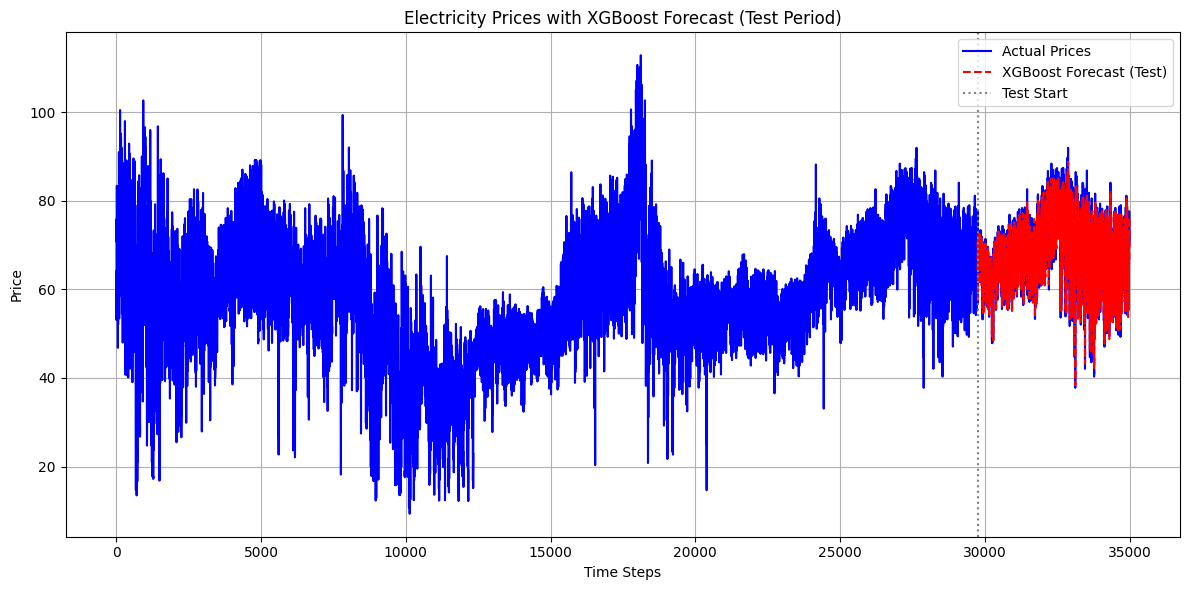

In [76]:
# ---------- Full Plot ----------
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(forecast_series, label="XGBoost Forecast (Test)", color='red', linestyle='--')
plt.axvline(x=len(y_train_inv) + len(y_val_inv), color='gray', linestyle=':', label='Test Start')
plt.title("Electricity Prices with XGBoost Forecast (Test Period)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

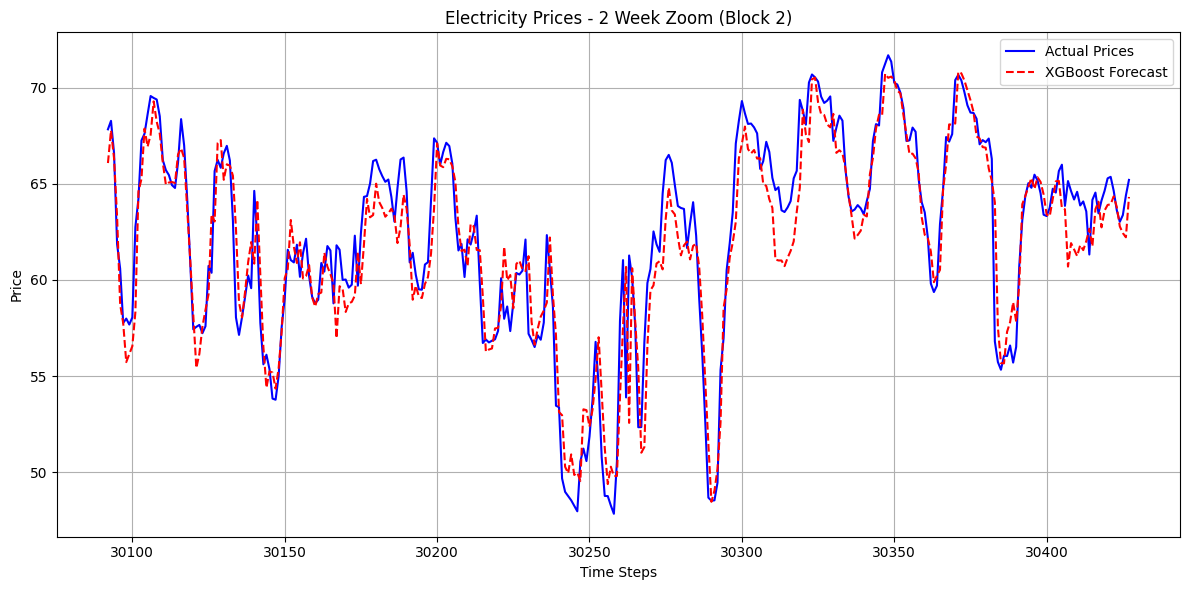

In [78]:
# ---------- Zoomed-in Plot (choose week_index) ----------
def plot_two_week_block(week_index: int = 0):
    """
    Plots a chosen 2-week block from the test set.
    week_index: 0 means the first 2 weeks of test set, 1 means the next 2 weeks, etc.
    """
    two_weeks = 24 * 14  # 336 data points
    test_start = len(y_train_inv) + len(y_val_inv)
    zoom_start = test_start + (week_index * two_weeks)
    zoom_end = zoom_start + two_weeks

    plt.figure(figsize=(12, 6))
    plt.plot(range(zoom_start, zoom_end), actual_prices[zoom_start:zoom_end],
             label="Actual Prices", color='blue')
    plt.plot(range(zoom_start, zoom_end), forecast_series[zoom_start:zoom_end],
             label="XGBoost Forecast", color='red', linestyle='--')
    plt.title(f"Electricity Prices - 2 Week Zoom (Block {week_index + 1})")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot the second 2-week block from the test set
plot_two_week_block(week_index = 1)